In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf
from pandas import TimeGrouper
from pandas import concat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
###

import sklearn.cross_validation
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score,auc,precision_recall_curve
from sklearn.cluster import KMeans
from sklearn import svm,tree
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.utils import shuffle
from datetime import datetime, date, timedelta
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from numpy.random import vonmises
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler


%matplotlib inline

# Datasets import

In [2]:
# Dataset to start
trainingTable1= pd.read_csv('BATADAL_dataset03.csv')

In [3]:
# Dataset to optimize
trainingTable2= pd.read_csv('BATADAL_dataset04.csv')

In [4]:
# Dataset to test 
testTable= pd.read_csv('BATADAL_test_dataset.csv')

# Preprocessing
    - Fix TrainingTable2 columns header
    - Check for null instances
    - Creation of DATETIME as new index for all the tables
    - Remove all the information that is not needed and keep only the sensors info
    - Creation of training data table



In [6]:
#Fixing trainingTable2 columns header
trainingTable2.head(n=10)
trainingTable2.columns = trainingTable2.columns.str.replace('\s+', '')

In [102]:
# Check for nulls
trainingTable1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2014-06-01 00:00:00 to 2015-06-01 00:00:00
Data columns (total 44 columns):
L_T1        8761 non-null float64
L_T2        8761 non-null float64
L_T3        8761 non-null float64
L_T4        8761 non-null float64
L_T5        8761 non-null float64
L_T6        8761 non-null float64
L_T7        8761 non-null float64
F_PU1       8761 non-null float64
S_PU1       8761 non-null int64
F_PU2       8761 non-null float64
S_PU2       8761 non-null int64
F_PU3       8761 non-null int64
S_PU3       8761 non-null int64
F_PU4       8761 non-null float64
S_PU4       8761 non-null int64
F_PU5       8761 non-null int64
S_PU5       8761 non-null int64
F_PU6       8761 non-null float64
S_PU6       8761 non-null int64
F_PU7       8761 non-null float64
S_PU7       8761 non-null int64
F_PU8       8761 non-null float64
S_PU8       8761 non-null int64
F_PU9       8761 non-null int64
S_PU9       8761 non-null int64
F_PU10      8761 non-null float

In [11]:
# Converting index
trainingTable1= trainingTable1.set_index('DATETIME')
trainingTable2= trainingTable2.set_index('DATETIME')
testTable= testTable.set_index('DATETIME')

L_T1        float64
L_T2        float64
L_T3        float64
L_T4        float64
L_T5        float64
L_T6        float64
L_T7        float64
F_PU1       float64
S_PU1         int64
F_PU2       float64
S_PU2         int64
F_PU3         int64
S_PU3         int64
F_PU4       float64
S_PU4         int64
F_PU5         int64
S_PU5         int64
F_PU6       float64
S_PU6         int64
F_PU7       float64
S_PU7         int64
F_PU8       float64
S_PU8         int64
F_PU9         int64
S_PU9         int64
F_PU10      float64
S_PU10        int64
F_PU11      float64
S_PU11        int64
F_V2        float64
S_V2          int64
P_J280      float64
P_J269      float64
P_J300      float64
P_J256      float64
P_J289      float64
P_J415      float64
P_J302      float64
P_J306      float64
P_J307      float64
P_J317      float64
P_J14       float64
P_J422      float64
ATT_FLAG      int64
dtype: object

In [104]:
## drop all the columns that present nan in adfuller test
dataToPlot = trainingTable1.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','S_PU10','S_PU11','S_V2','ATT_FLAG'])

dataToPlot2 = trainingTable2.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','S_PU10','S_PU11','S_V2','ATT_FLAG'])


In [17]:
testToPlot = testTable.drop(columns=['S_PU1','S_PU2', 'F_PU3','S_PU3','S_PU4','F_PU5','F_PU6','S_PU5','S_PU6','S_PU7','S_PU8','F_PU9','S_PU9','S_PU10','S_PU11','S_V2'])


In [18]:
# creates one single table for all the training data
frames = [dataToPlot,dataToPlot2]

trainingTable = pd.concat(frames)

# Visualisation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c25af0710>,
      dtype=object)

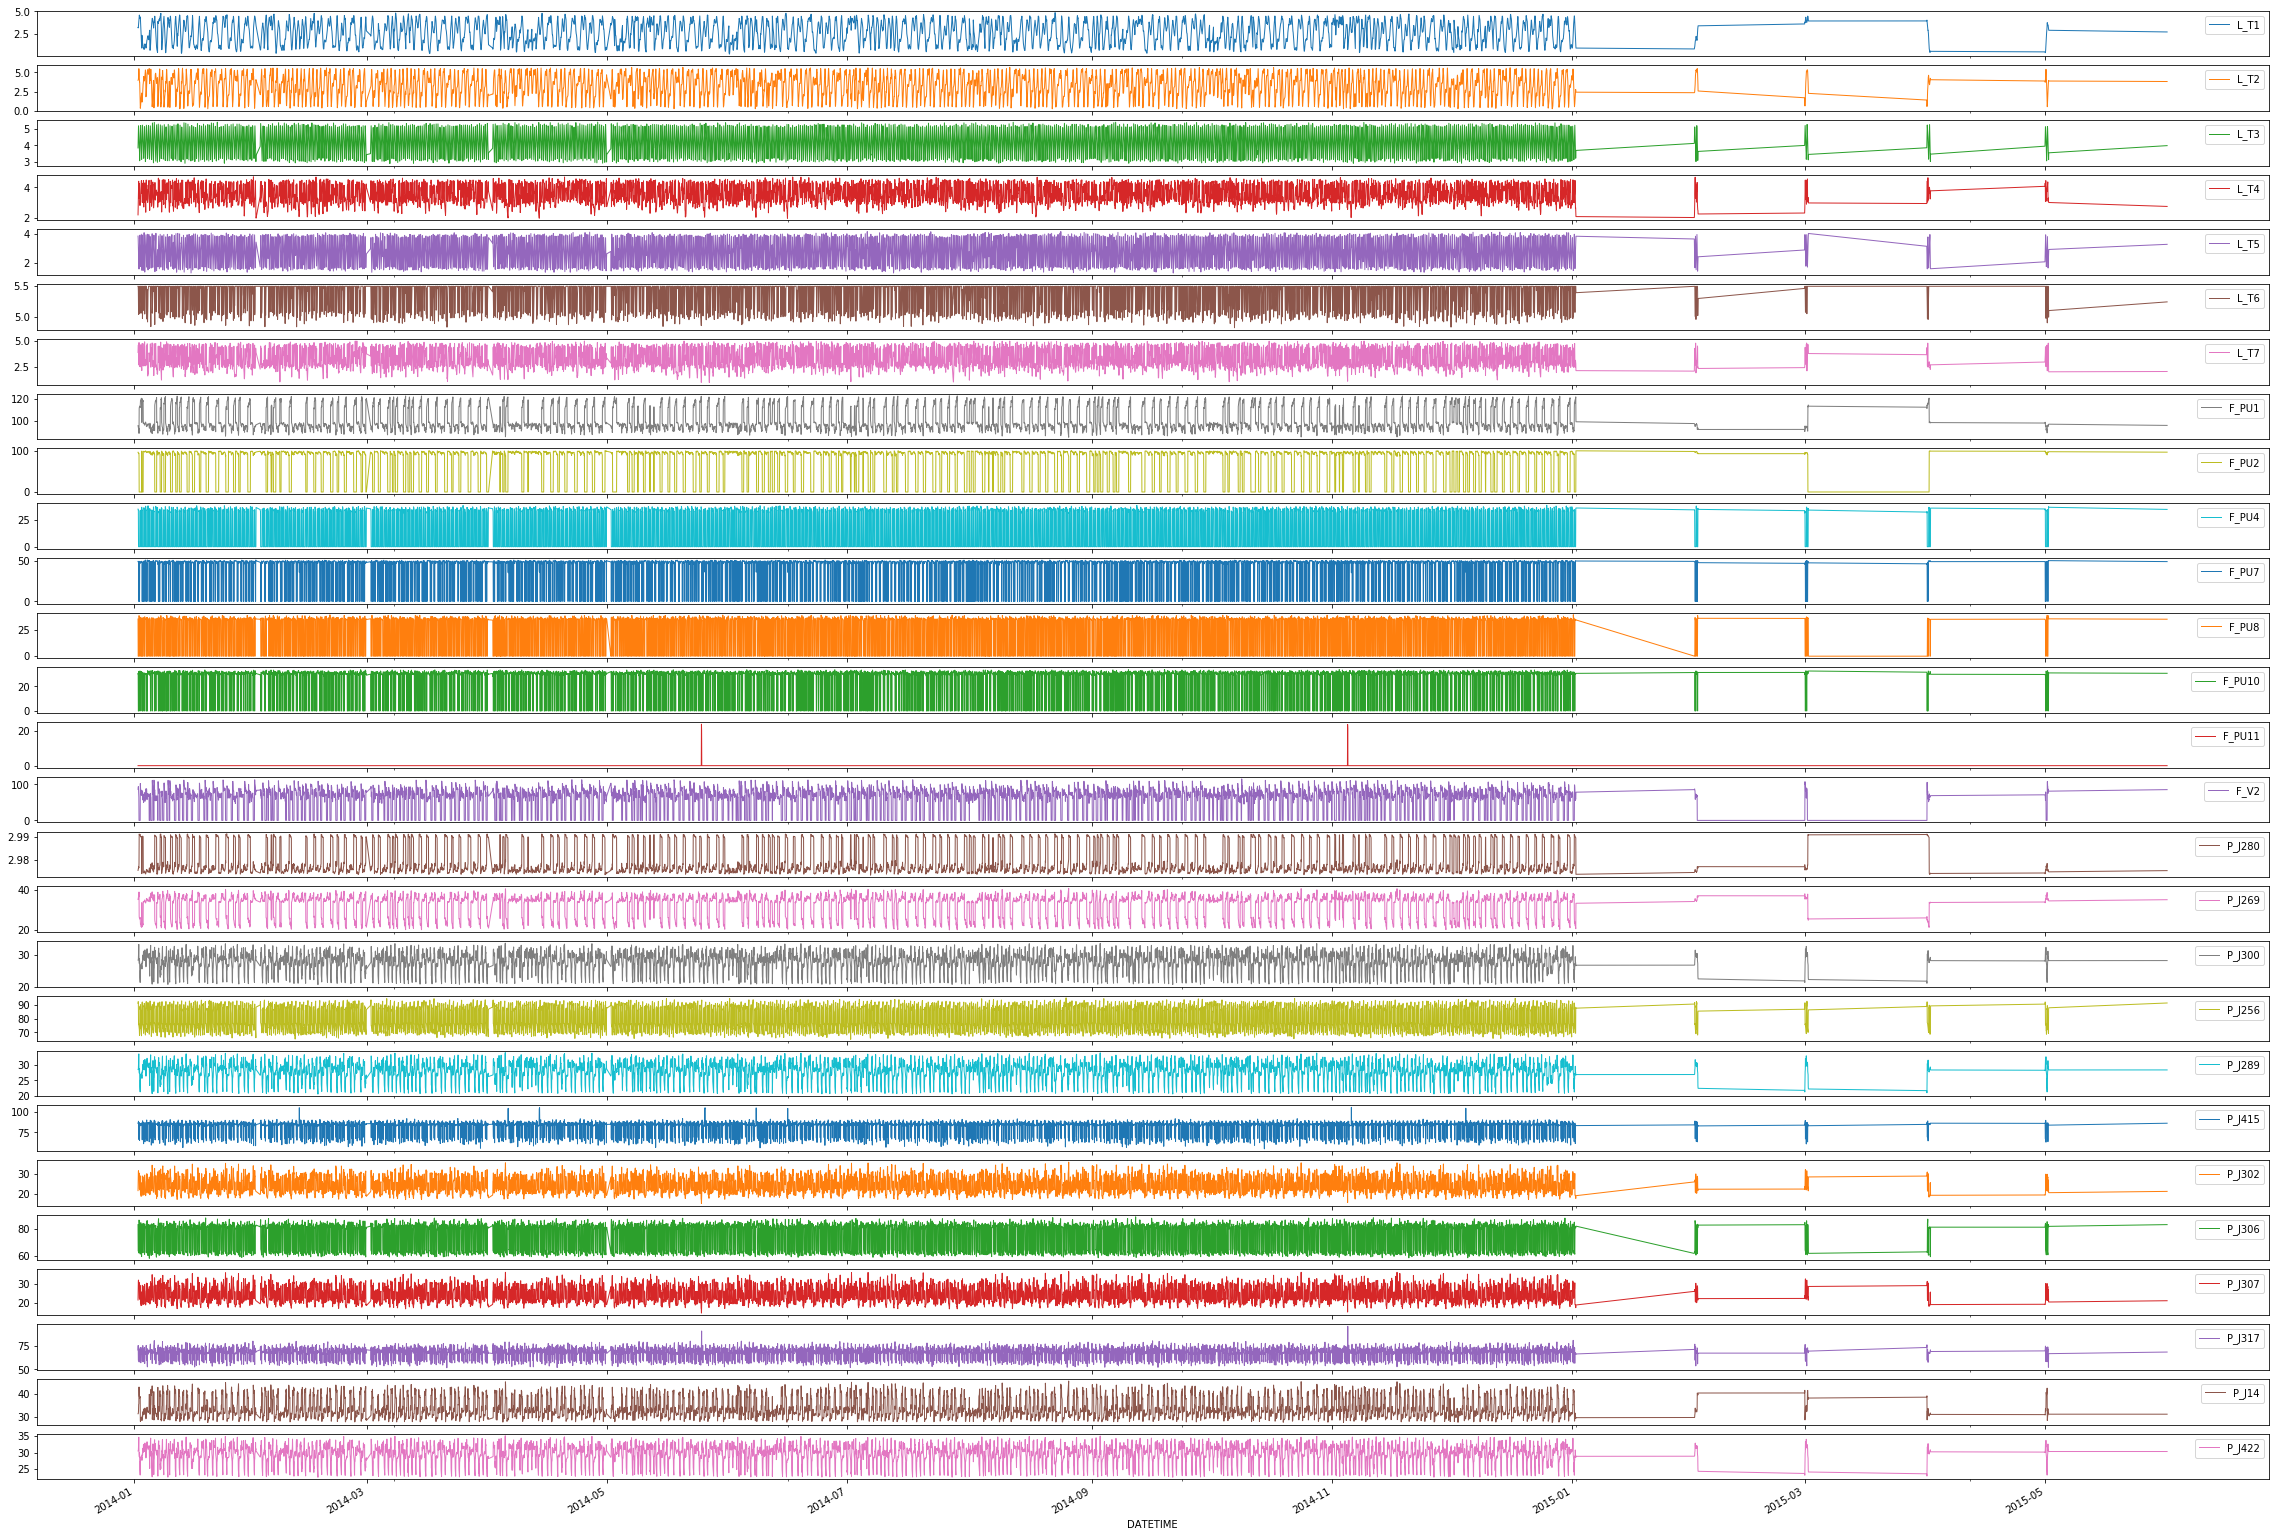

In [105]:
dataToPlot.plot(subplots=True,linewidth=1,kind='line',figsize=(40,30),sharex=True,sharey=False)

### Correlations between time series

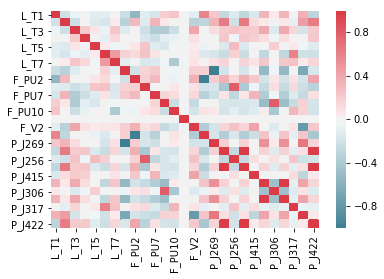

In [39]:
sns.heatmap(dataToPlot.corr(method='spearman'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

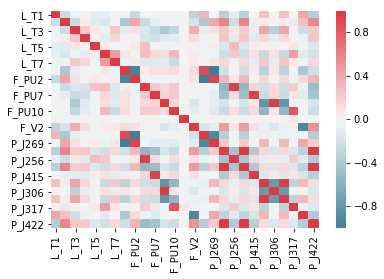

In [40]:
sns.heatmap(dataToPlot.corr(method='pearson'), mask=np.zeros_like(dataToPlot.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True))

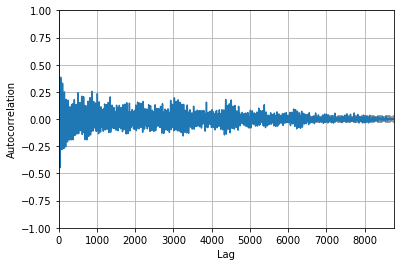

In [23]:
pd.plotting.autocorrelation_plot(test);

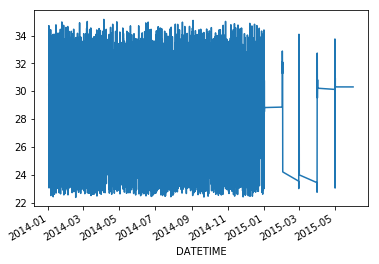

In [24]:
trainingTable1['P_J422'].plot()

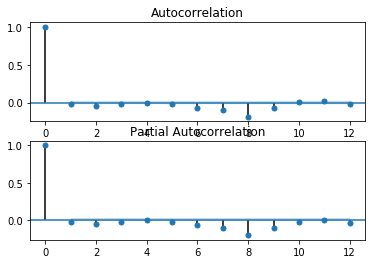

In [362]:
chg_temp = trainingTable1['F_V2'].diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF 
plot_acf(chg_temp, lags=12, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=12, ax=axes[1])
plt.show()

In [32]:
# test if sensors are random walk 

columnsSize = dataToPlot.columns.size
columns = list(range(columnsSize))
print(columns)
results = [adfuller(dataToPlot.iloc[:,column]) for column in columns]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [33]:
count = 0 
colNames = trainingTable1.columns.values.tolist()
for result in results:
    print('==================================')
    print('Column %s' %colNames[count])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    count = count + 1

Column L_T1
ADF Statistic: -20.615633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T2
ADF Statistic: -18.612726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T3
ADF Statistic: -14.375782
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T4
ADF Statistic: -16.582866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T5
ADF Statistic: -18.509403
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T6
ADF Statistic: -18.364822
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column L_T7
ADF Statistic: -17.489711
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F_PU1
ADF Statistic: -27.596471
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column S_PU1
ADF Statistic: -27.586431
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Column F

In [34]:
# 

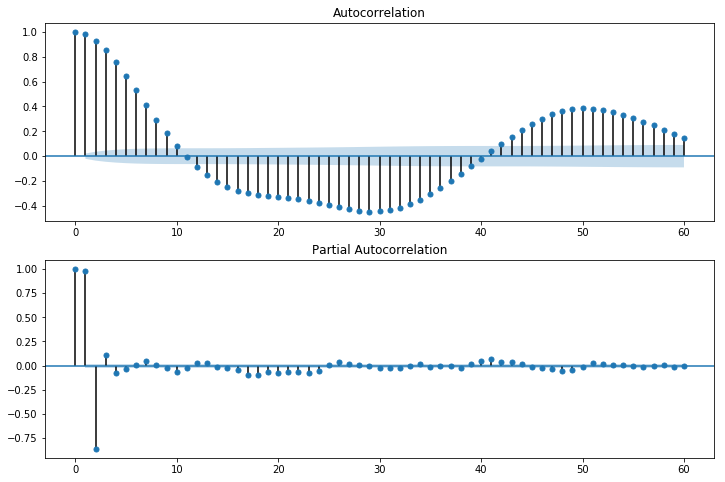

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainingTable1['L_T1'], lags=60, ax=ax1,alpha=0.05)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainingTable1['L_T1'], lags=60, ax=ax2,alpha=0.05)
plt.show()

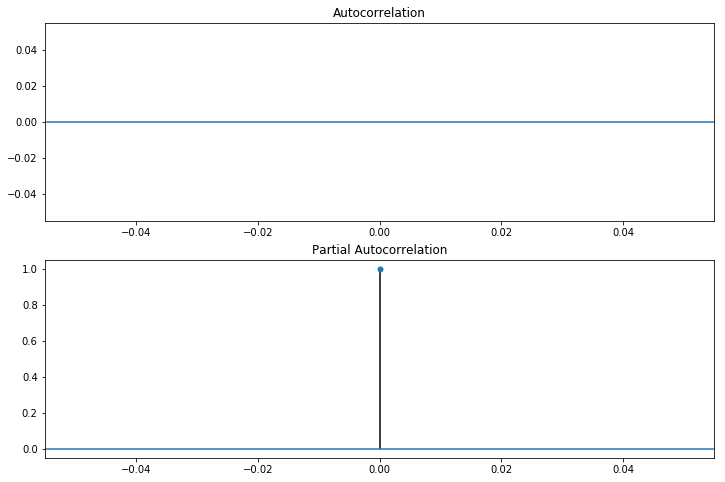

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trainingTable1['L_T1'].diff(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trainingTable1['L_T1'].diff(), lags=60, ax=ax2)
plt.show()

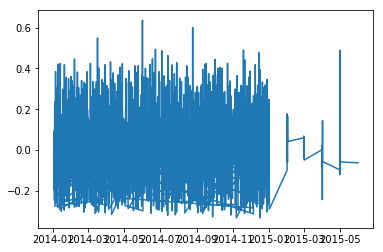

In [37]:
plt.plot(trainingTable1['L_T1'].pct_change())

In [38]:
print(acf(trainingTable1['F_PU1']))

[ 1.          0.88842832  0.7779471   0.67365269  0.5712454   0.46768877
  0.36262662  0.25456042  0.14871147  0.05212462 -0.02901983 -0.10335739
 -0.16900937 -0.22121146 -0.25921387 -0.28397782 -0.29464691 -0.29730426
 -0.29925067 -0.30631712 -0.31379347 -0.32224706 -0.3315234  -0.33890313
 -0.34713295 -0.35686197 -0.3637945  -0.36427606 -0.3605646  -0.3511266
 -0.33958139 -0.32250248 -0.29992968 -0.26948004 -0.23002061 -0.18601731
 -0.14002935 -0.09269629 -0.04445145  0.00326373  0.05444767]


L_T1


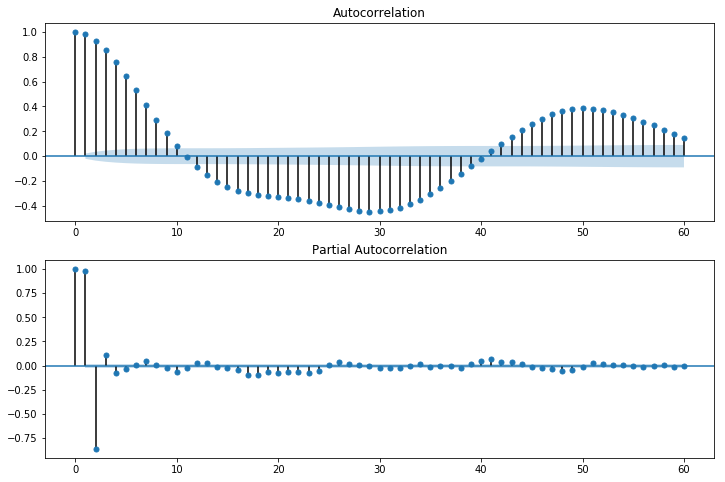

L_T2


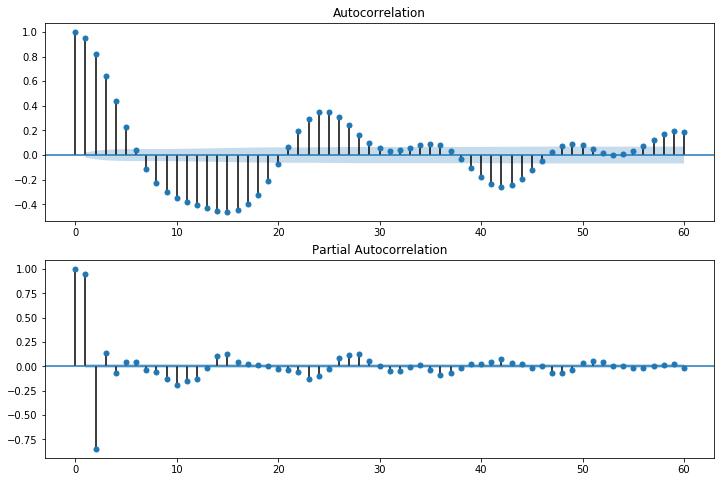

L_T3


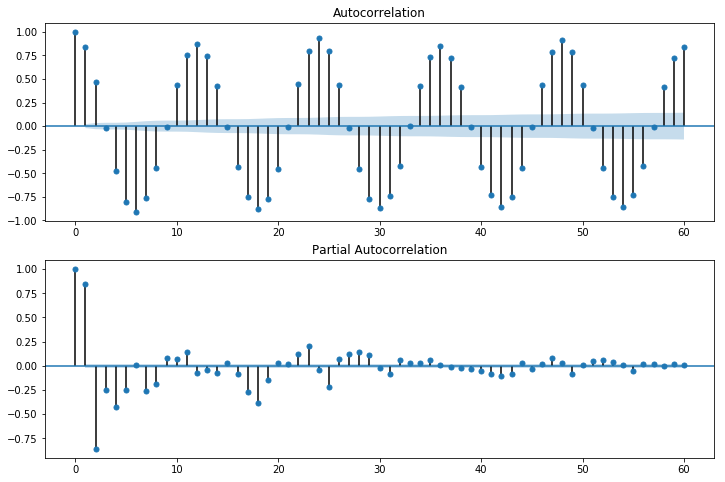

L_T4


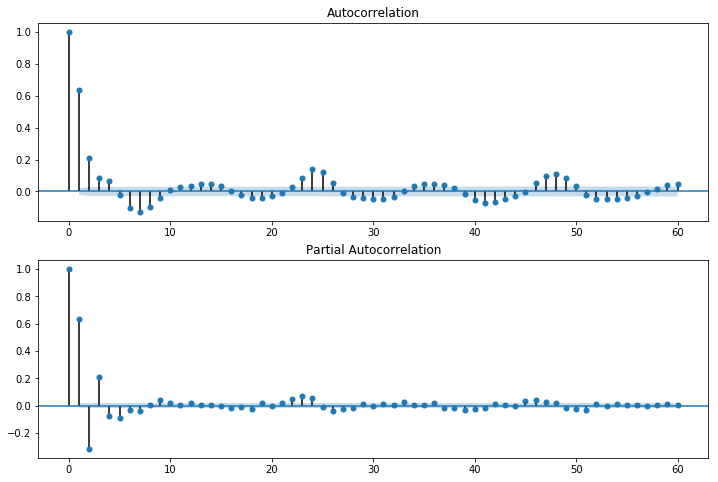

L_T5


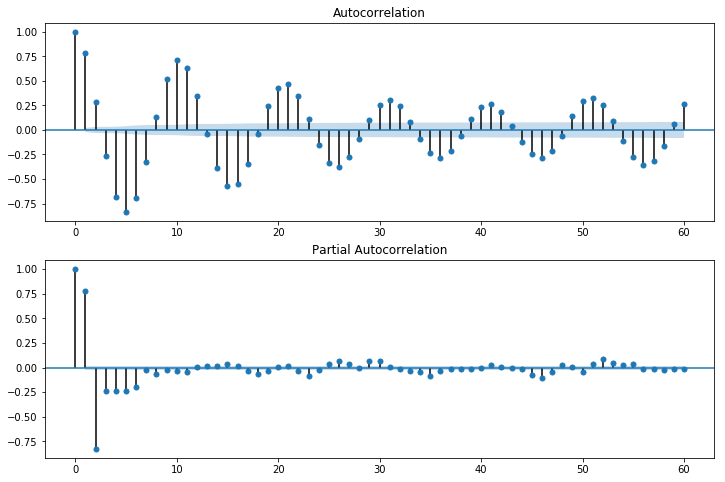

L_T6


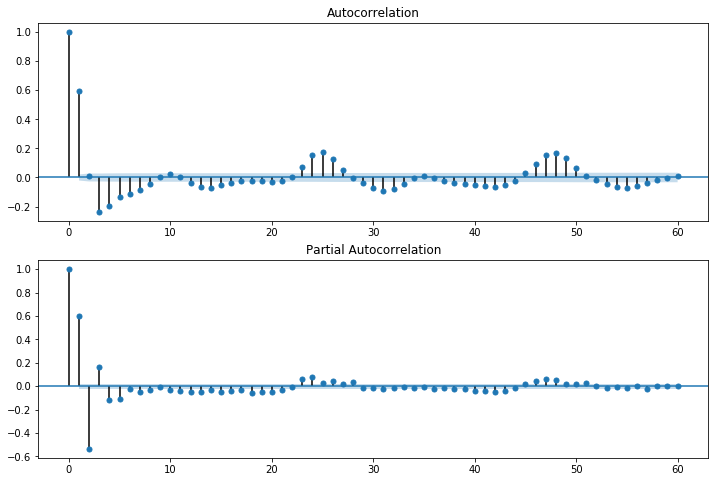

L_T7


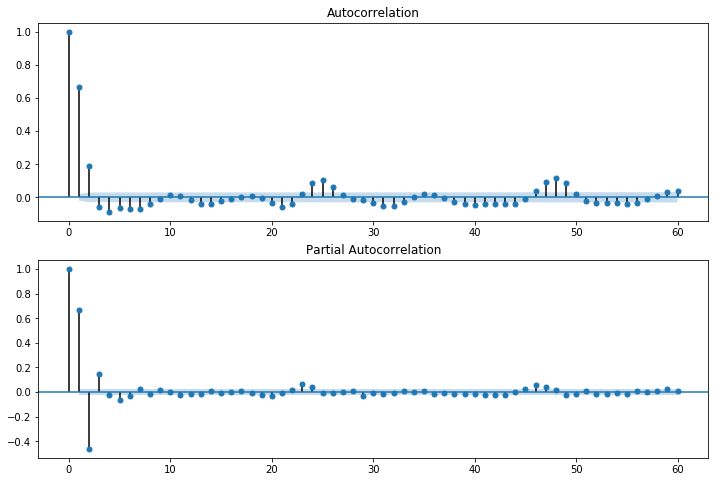

F_PU1


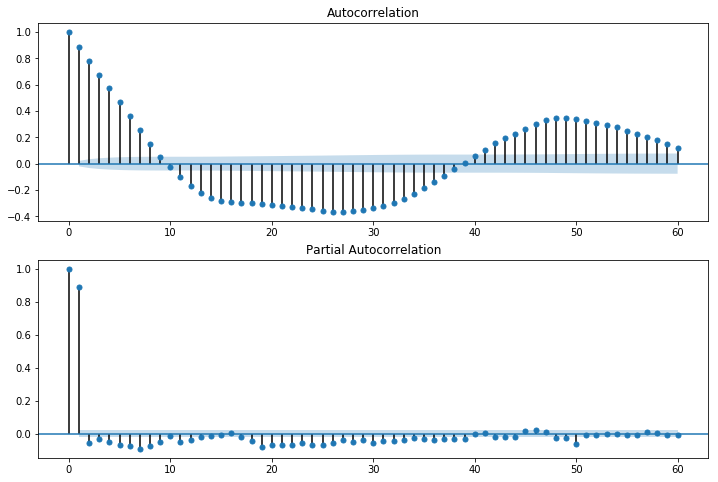

F_PU2


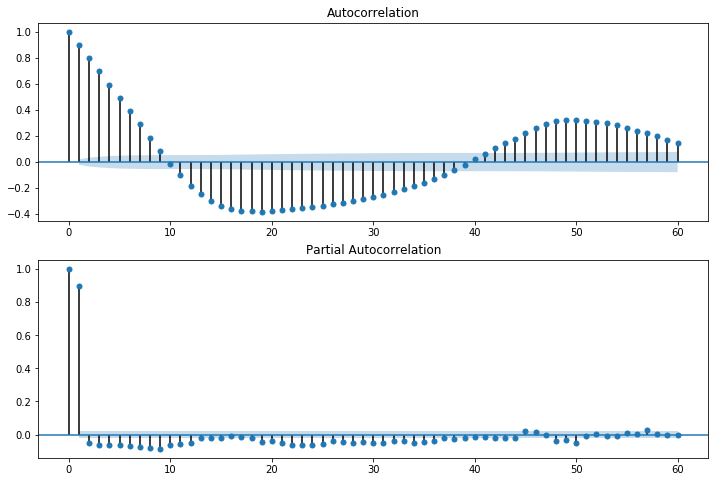

F_PU4


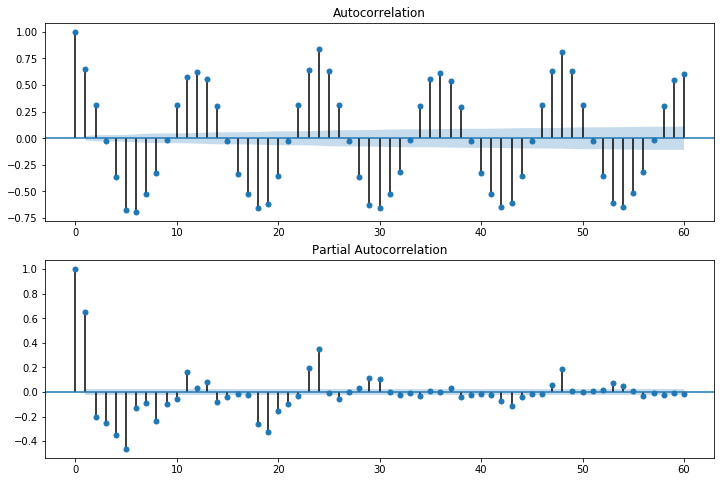

F_PU7


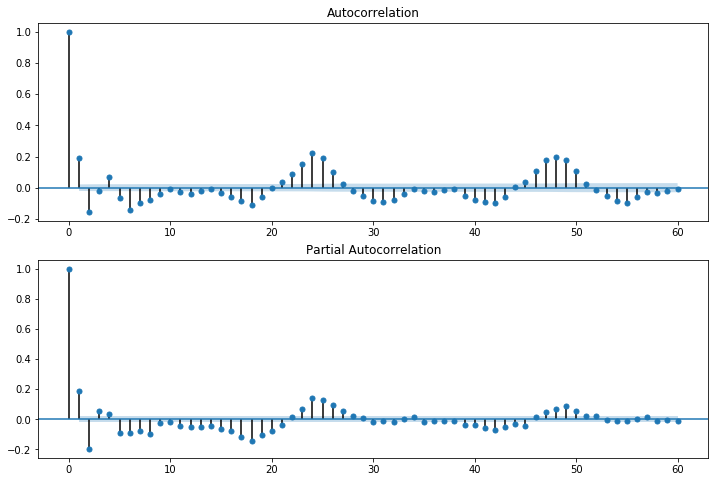

F_PU8


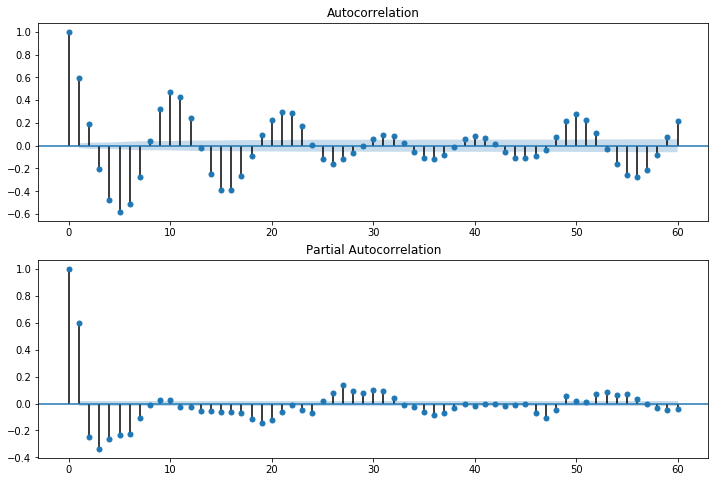

F_PU10


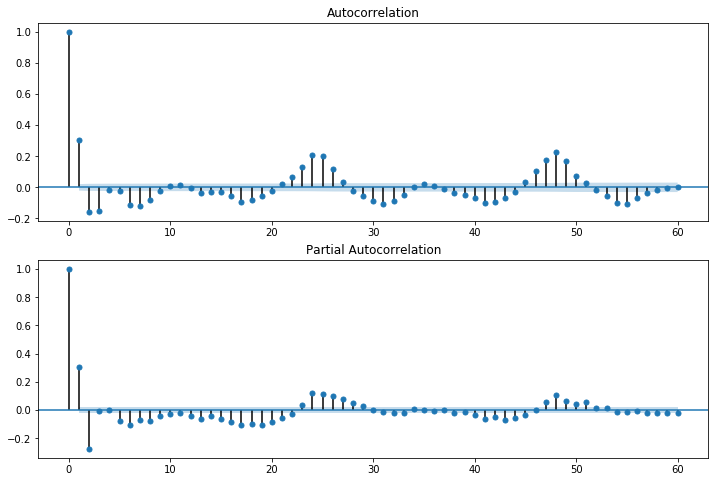

F_PU11


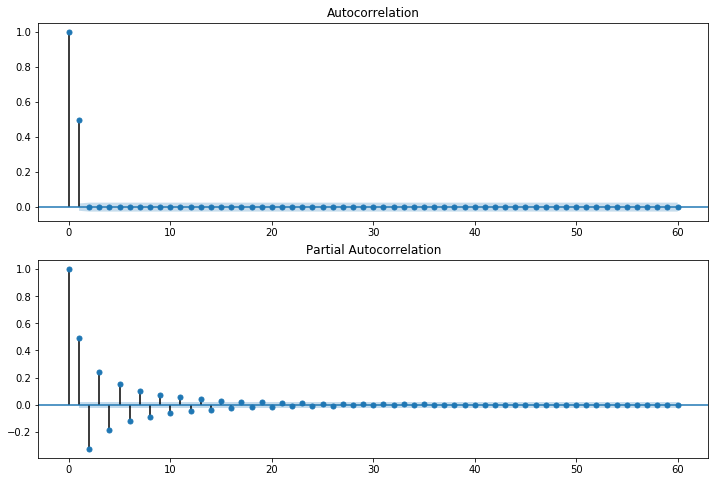

F_V2


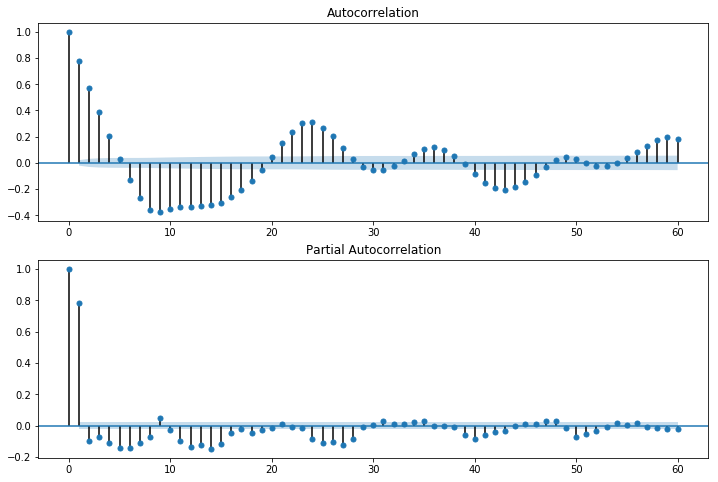

P_J280


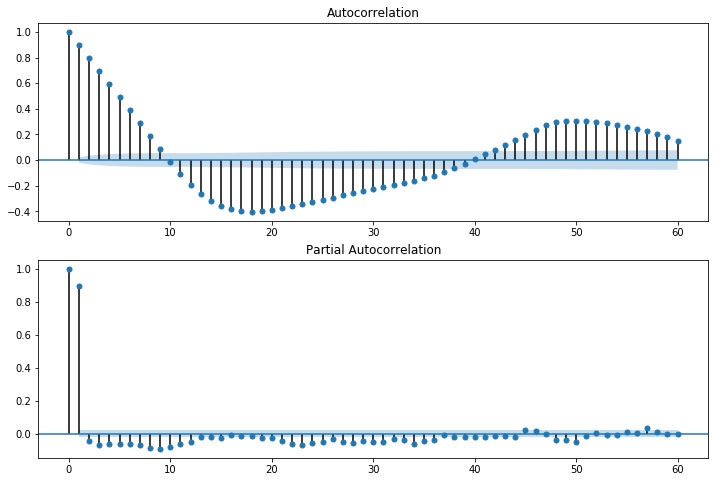

P_J269


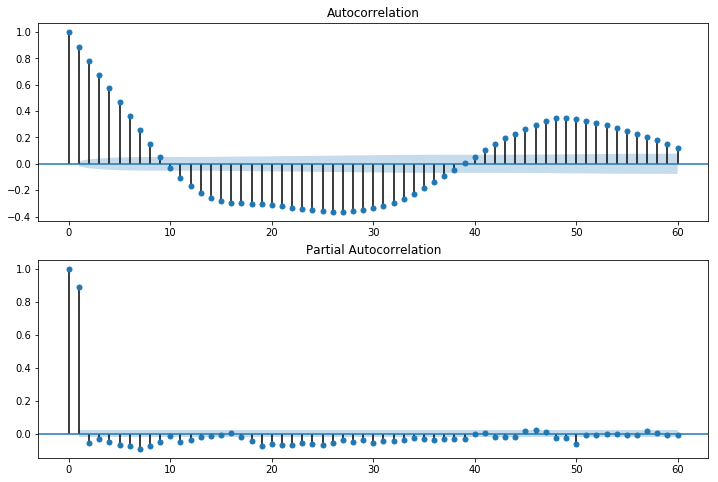

P_J300


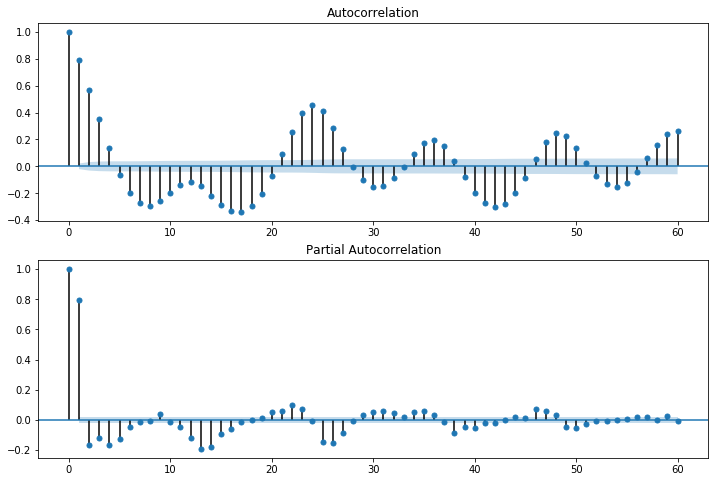

P_J256


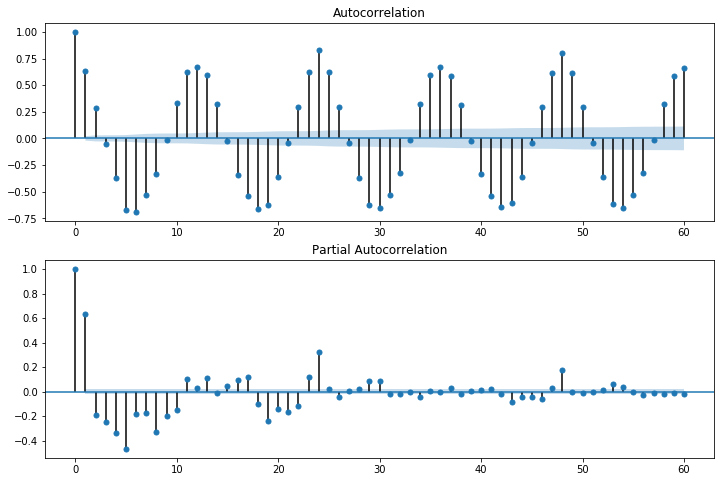

P_J289


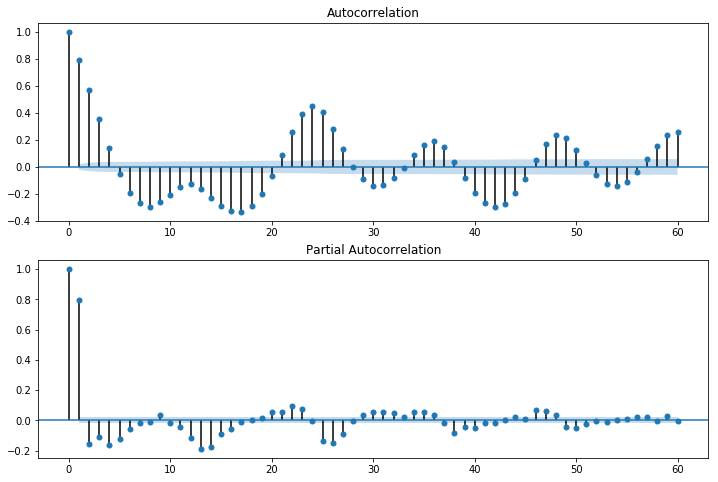

P_J415


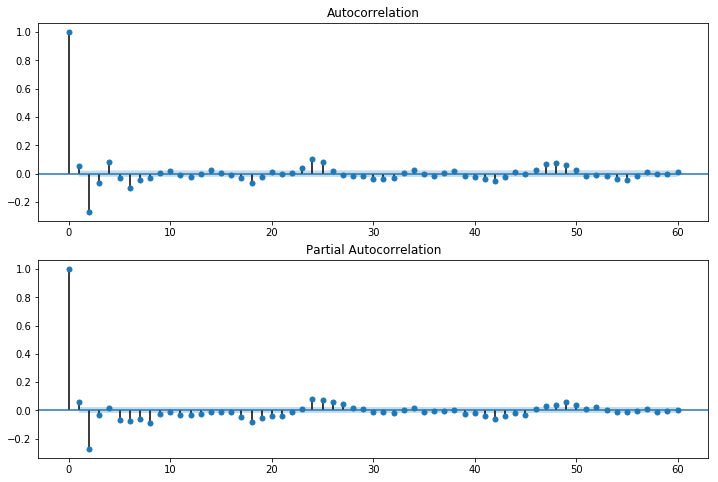

P_J302


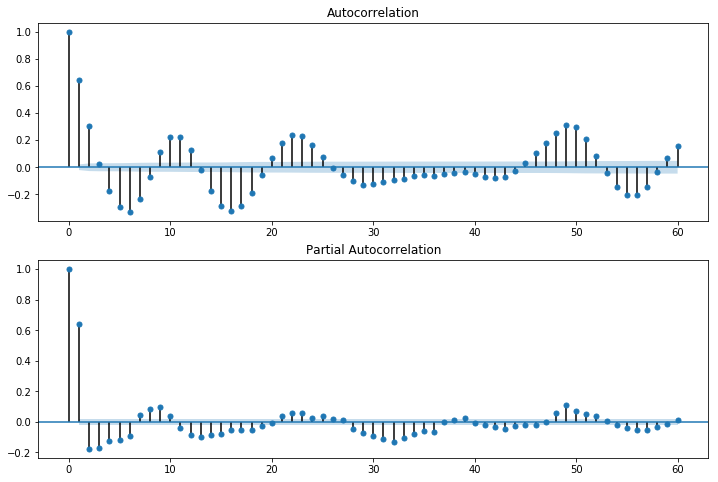

P_J306


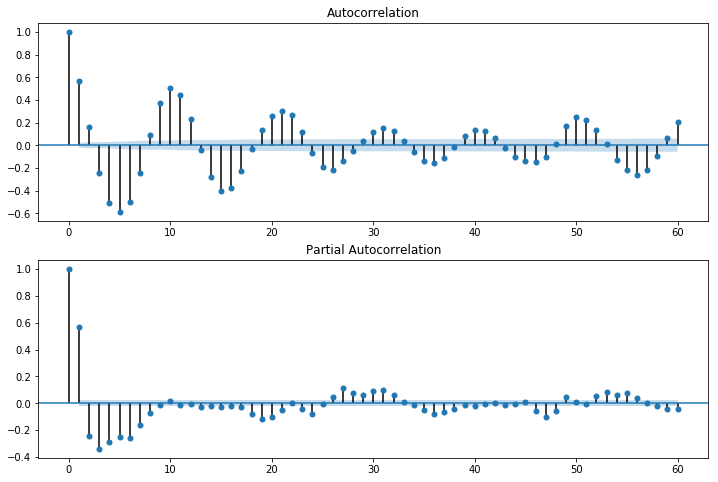

P_J307


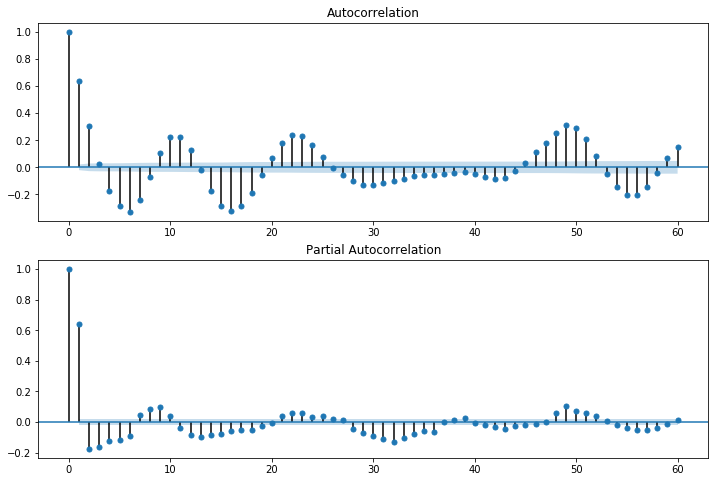

P_J317


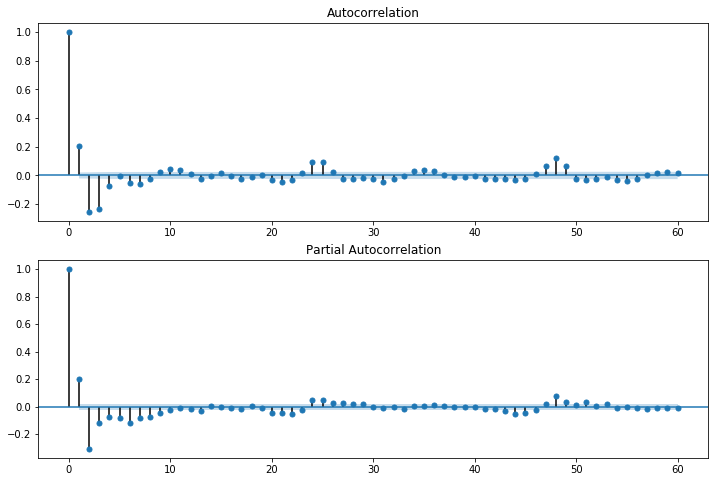

P_J14


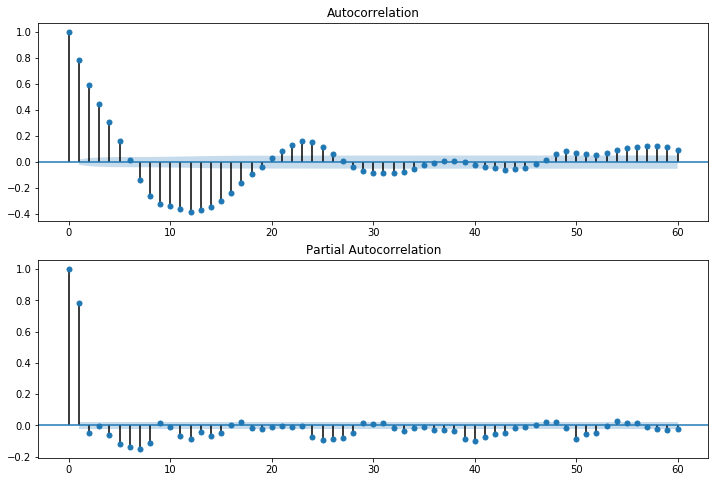

P_J422


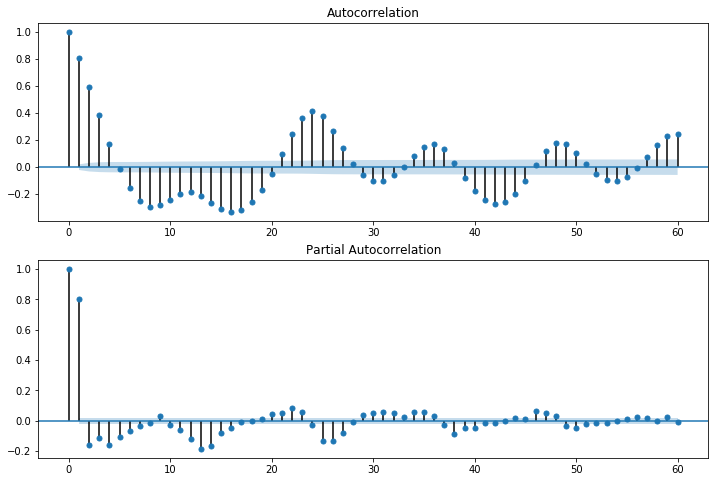

In [41]:
for column in columns:
    print(dataToPlot.iloc[:,column].name)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(dataToPlot.iloc[:,column], lags=60, ax=ax1,alpha=0.05)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(dataToPlot.iloc[:,column], lags=60, ax=ax2,alpha=0.05)
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


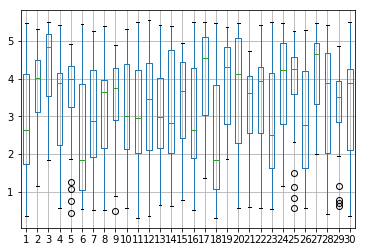

In [372]:
series = dataToPlot.iloc[:,1]
one_year = series['2014-01']
groups = one_year.groupby(TimeGrouper('D'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,31)
months.boxplot()
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


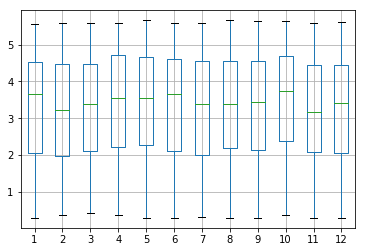

In [364]:
series = dataToPlot.iloc[:,1]
one_year = series['2014']
groups = one_year.groupby(TimeGrouper('M'))
months = concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.show()

# parameters are determined based o training data

In [342]:
columnsSize = trainingTable.columns.size
#columns = list(range(columnsSize))
columns = list(range(4))
for column in columns:
    bestAIC = 9999999
    bestAR = -1
    bestMA=-1
    for p in list(range(5)):
        for q in list(range(5)):
            model = ARMA(trainingTable.iloc[:,column],order=(p,q)).fit(transparams=True)
            if model.aic < bestAIC:
                bestAIC = model.aic
                bestAR = p
                bestMA = q
    print('-------------------')
    print(trainingTable.iloc[:,column].name)
    print('AIC: {:.2f}'.format(bestAIC))
    print('AR parameter {}'.format(bestAR))
    print('MA parameter {}'.format(bestMA))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


-------------------
L_T1
AIC: -16903.90
AR parameter 5
MA parameter 1
-------------------
L_T2
AIC: -566.84
AR parameter 6
MA parameter 1
-------------------
L_T3
AIC: -11327.68
AR parameter 6
MA parameter 1
-------------------
L_T4
AIC: 12043.38
AR parameter 5
MA parameter 1


In [106]:
trainingTable.describe()

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU4,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
count,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,...,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000,12938.000000
mean,2.686765,3.286463,4.202684,3.564288,2.748261,5.369789,3.309348,100.897956,69.439028,14.535882,...,27.765288,79.408865,27.775404,82.714266,24.492902,74.460441,24.400927,67.954949,33.804423,29.451418
std,1.205141,1.469159,0.679373,0.541363,0.735340,0.177487,0.831882,10.103245,42.219150,17.034699,...,2.747155,8.465908,2.726682,7.526889,4.513962,9.988760,4.536265,5.423225,4.355064,2.664868
min,0.320000,0.293876,2.880000,1.920000,1.280000,4.770000,0.430000,38.920000,0.000000,0.000000,...,19.440000,65.059624,19.460000,53.940000,13.910000,58.070000,13.640000,51.410000,27.649677,21.320000
25%,1.650107,2.140000,3.621822,3.136939,2.123902,5.247894,2.640000,94.272835,0.000000,0.000000,...,26.650366,71.971269,26.671427,83.897675,20.512255,62.947651,20.404883,66.706024,30.674677,28.432352
50%,2.805716,3.497673,4.239535,3.568694,2.757831,5.500000,3.260000,96.708542,94.009826,0.000000,...,28.120661,75.857258,28.119866,85.210000,23.020982,81.174259,22.909769,68.824566,32.231020,29.831979
75%,3.760000,4.576503,4.797688,4.006053,3.371283,5.500000,4.001064,112.265146,96.585197,34.016390,...,29.563946,88.209219,29.560000,86.407928,28.499280,82.666950,28.417975,71.269618,38.160000,31.279541
max,5.730000,5.670000,5.433022,4.700000,4.162726,5.500000,5.000000,122.705627,100.140671,38.296165,...,34.260000,94.961258,34.260000,107.950000,71.110000,95.270000,71.110000,96.180450,77.410000,35.680000


# Residuals

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                   L_T2   No. Observations:                12938
Model:                     ARMA(5, 1)   Log Likelihood                 226.320
Method:                       css-mle   S.D. of innovations              0.238
Date:                Wed, 30 May 2018   AIC                           -436.640
Time:                        15:18:29   BIC                           -376.897
Sample:                    06-01-2014   HQIC                          -416.674
                         - 12-25-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2864      0.015    214.298      0.000       3.256       3.316
ar.L1.L_T2     2.7949      0.013    215.640      0.000       2.769       2.820
ar.L2.L_T2    -2.8757      0.032    -90.474      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                  0
count  12938.000000
mean      -0.000058
std        0.237982
min       -1.920474
25%       -0.154763
50%       -0.009099
75%        0.132903
max        1.482152


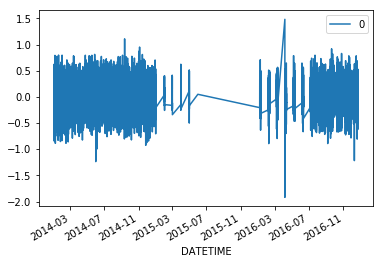

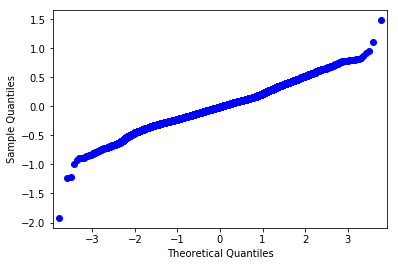

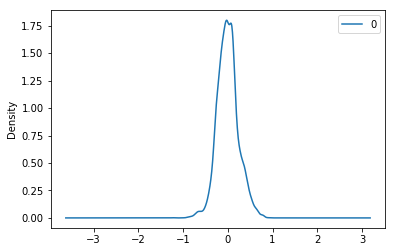

In [132]:
# fit model
model = ARMA(trainingTable.iloc[:,1], order=(5,1))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

residuals2 = np.array(model_fit.resid)
sm.qqplot(residuals2)

residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
## TODO Report
#In this case : 
##The results show that indeed there is no bias in the prediction (an approximately zero mean in the residuals).



# Performance

In [381]:
## TODO : for all columns , only need to substitute 1 for column
for column in columns:
    history = [x for x in trainingTable.iloc[:,1]]
    predictions = list()
    errors=  list()
    thrs = 3.5
    residuals = []
    for i in range(len(testTable.iloc[:,1])):
        model = ARMA(trainingTable1.iloc[:,1],order=(1,0))
        model_fit= model.fit()
        yhat = model.predict(trainingTable.iloc[:,1])
        #predict
        predictions.append(yhat[i])
        # observation
        obs = testTable.iloc[:,1][i]
        history.append(obs)
        print('>Predicted=%.3f, Expected=%3.f' % (yhat[i], obs))
        diff = abs(obs - yhat[i])
        errors.append(obs)
        residuals.append(diff)
        if diff > thrs:
            print('ALERT ANOMALY ?')
    # report performance
    mse = mean_squared_error(testTable.iloc[:,1], predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


>Predicted=2.049, Expected=  2
>Predicted=2.049, Expected=  2
>Predicted=1.969, Expected=  2
>Predicted=1.923, Expected=  3
>Predicted=1.969, Expected=  3
>Predicted=2.129, Expected=  4
>Predicted=3.504, Expected=  4
>Predicted=5.037, Expected=  5
>Predicted=5.713, Expected=  5
>Predicted=6.247, Expected=  5
>Predicted=6.973, Expected=  5
>Predicted=7.901, Expected=  5
>Predicted=8.177, Expected=  5
>Predicted=8.311, Expected=  5
>Predicted=7.969, Expected=  5
>Predicted=7.577, Expected=  5
>Predicted=7.220, Expected=  5
>Predicted=6.970, Expected=  5
>Predicted=6.891, Expected=  5
>Predicted=7.360, Expected=  4
>Predicted=8.381, Expected=  4
ALERT ANOMALY ?
>Predicted=8.664, Expected=  3
ALERT ANOMALY ?
>Predicted=7.585, Expected=  2
ALERT ANOMALY ?
>Predicted=6.512, Expected=  1
ALERT ANOMALY ?
>Predicted=5.268, Expected=  1
ALERT ANOMALY ?
>Predicted=3.514, Expected=  1
>Predicted=1.772, Expected=  1
>Predicted=0.063, Expected=  2
>Predicted=-0.865, Expected=  2
>Predicted=-0.051, E

>Predicted=6.243, Expected=  0
ALERT ANOMALY ?
>Predicted=4.523, Expected=  1
ALERT ANOMALY ?
>Predicted=3.317, Expected=  1
>Predicted=2.280, Expected=  1
>Predicted=1.251, Expected=  2
>Predicted=0.219, Expected=  2
>Predicted=-0.812, Expected=  2
>Predicted=-0.389, Expected=  2
>Predicted=-0.264, Expected=  2
>Predicted=-0.262, Expected=  2
>Predicted=-0.357, Expected=  2
>Predicted=-0.472, Expected=  2
>Predicted=-0.534, Expected=  3
>Predicted=0.492, Expected=  3
>Predicted=1.679, Expected=  4
>Predicted=2.356, Expected=  4
>Predicted=2.983, Expected=  5
>Predicted=4.183, Expected=  5
>Predicted=4.887, Expected=  5
>Predicted=5.363, Expected=  5
>Predicted=5.828, Expected=  5
>Predicted=5.555, Expected=  5
>Predicted=5.288, Expected=  5
>Predicted=5.109, Expected=  5
>Predicted=5.100, Expected=  5
>Predicted=6.010, Expected=  6
>Predicted=6.408, Expected=  5
>Predicted=6.824, Expected=  4
>Predicted=7.247, Expected=  4
>Predicted=7.630, Expected=  3
ALERT ANOMALY ?
>Predicted=7.86

>Predicted=8.160, Expected=  2
ALERT ANOMALY ?
>Predicted=7.821, Expected=  1
ALERT ANOMALY ?
>Predicted=7.521, Expected=  0
ALERT ANOMALY ?
>Predicted=7.795, Expected=  1
ALERT ANOMALY ?
>Predicted=8.958, Expected=  1
ALERT ANOMALY ?
>Predicted=7.897, Expected=  2
ALERT ANOMALY ?
>Predicted=6.837, Expected=  2
ALERT ANOMALY ?
>Predicted=5.786, Expected=  2
ALERT ANOMALY ?
>Predicted=4.729, Expected=  2
>Predicted=3.673, Expected=  2
>Predicted=2.025, Expected=  2
>Predicted=0.254, Expected=  2
>Predicted=-0.952, Expected=  2
>Predicted=-0.418, Expected=  2
>Predicted=0.184, Expected=  2
>Predicted=0.936, Expected=  3
>Predicted=2.606, Expected=  4
>Predicted=4.401, Expected=  4
>Predicted=5.432, Expected=  4
>Predicted=6.150, Expected=  5
>Predicted=7.241, Expected=  5
>Predicted=8.130, Expected=  5
>Predicted=8.410, Expected=  5
>Predicted=8.513, Expected=  5
>Predicted=8.189, Expected=  5
>Predicted=7.614, Expected=  5
>Predicted=7.110, Expected=  5
>Predicted=6.647, Expected=  5
>P

>Predicted=-0.249, Expected=  4
ALERT ANOMALY ?
>Predicted=0.628, Expected=  4
ALERT ANOMALY ?
>Predicted=1.412, Expected=  4
>Predicted=1.918, Expected=  3
>Predicted=2.618, Expected=  2
>Predicted=3.261, Expected=  2
>Predicted=2.768, Expected=  2
>Predicted=2.378, Expected=  1
>Predicted=2.325, Expected=  1
>Predicted=2.345, Expected=  1
>Predicted=2.493, Expected=  2
>Predicted=3.297, Expected=  3
>Predicted=4.881, Expected=  3
>Predicted=6.341, Expected=  4
>Predicted=6.970, Expected=  4
>Predicted=7.534, Expected=  4
>Predicted=7.908, Expected=  4
ALERT ANOMALY ?
>Predicted=8.270, Expected=  4
ALERT ANOMALY ?
>Predicted=8.631, Expected=  4
ALERT ANOMALY ?
>Predicted=8.564, Expected=  4
ALERT ANOMALY ?
>Predicted=8.606, Expected=  3
ALERT ANOMALY ?
>Predicted=6.843, Expected=  3
ALERT ANOMALY ?
>Predicted=5.113, Expected=  3
>Predicted=3.449, Expected=  4
>Predicted=2.404, Expected=  4
>Predicted=1.379, Expected=  4
>Predicted=0.350, Expected=  5
ALERT ANOMALY ?
>Predicted=-0.677,

>Predicted=5.695, Expected=  4
>Predicted=6.261, Expected=  5
>Predicted=7.477, Expected=  5
>Predicted=8.844, Expected=  5
ALERT ANOMALY ?
>Predicted=8.084, Expected=  5
>Predicted=7.057, Expected=  4
>Predicted=6.575, Expected=  4
>Predicted=6.032, Expected=  4
>Predicted=4.969, Expected=  3
>Predicted=3.382, Expected=  2
>Predicted=1.640, Expected=  1
>Predicted=-0.103, Expected=  1
>Predicted=-0.909, Expected=  1
>Predicted=-0.510, Expected=  1
>Predicted=-0.144, Expected=  2
>Predicted=0.552, Expected=  2
>Predicted=1.240, Expected=  3
>Predicted=2.522, Expected=  3
>Predicted=3.131, Expected=  3
>Predicted=3.441, Expected=  4
>Predicted=3.633, Expected=  4
>Predicted=3.160, Expected=  4
>Predicted=3.052, Expected=  4
>Predicted=3.002, Expected=  4
>Predicted=2.983, Expected=  5
>Predicted=3.093, Expected=  5
>Predicted=3.649, Expected=  6
>Predicted=4.628, Expected=  6
>Predicted=5.923, Expected=  5
>Predicted=6.569, Expected=  5
>Predicted=7.127, Expected=  4
>Predicted=7.559, E

>Predicted=3.586, Expected=  1
>Predicted=1.868, Expected=  1
>Predicted=0.174, Expected=  1
>Predicted=-0.793, Expected=  1
>Predicted=0.263, Expected=  2
>Predicted=1.229, Expected=  2
>Predicted=2.301, Expected=  3
>Predicted=3.730, Expected=  3
>Predicted=4.440, Expected=  3
>Predicted=4.905, Expected=  2
>Predicted=4.798, Expected=  2
>Predicted=4.702, Expected=  2
>Predicted=4.754, Expected=  2
>Predicted=4.908, Expected=  3
>Predicted=5.284, Expected=  3
>Predicted=6.479, Expected=  4
>Predicted=8.046, Expected=  4
ALERT ANOMALY ?
>Predicted=9.106, Expected=  4
ALERT ANOMALY ?
>Predicted=8.071, Expected=  5
>Predicted=7.435, Expected=  5
>Predicted=7.219, Expected=  5
>Predicted=6.160, Expected=  5
>Predicted=5.101, Expected=  5
>Predicted=3.632, Expected=  5
>Predicted=1.882, Expected=  5
>Predicted=0.155, Expected=  5
ALERT ANOMALY ?
>Predicted=-0.975, Expected=  5
ALERT ANOMALY ?
>Predicted=-0.881, Expected=  5
ALERT ANOMALY ?
>Predicted=-0.906, Expected=  5
ALERT ANOMALY ?
>

>Predicted=7.271, Expected=  4
ALERT ANOMALY ?
>Predicted=5.606, Expected=  4
>Predicted=3.819, Expected=  4
>Predicted=2.059, Expected=  4
>Predicted=0.316, Expected=  4
>Predicted=-0.958, Expected=  4
ALERT ANOMALY ?
>Predicted=-0.255, Expected=  5
ALERT ANOMALY ?
>Predicted=0.870, Expected=  5
ALERT ANOMALY ?
>Predicted=2.220, Expected=  5
>Predicted=3.947, Expected=  5
>Predicted=5.199, Expected=  5
>Predicted=5.994, Expected=  4
>Predicted=6.738, Expected=  3
>Predicted=7.317, Expected=  3
ALERT ANOMALY ?
>Predicted=7.288, Expected=  2
ALERT ANOMALY ?
>Predicted=7.230, Expected=  1
ALERT ANOMALY ?
>Predicted=7.212, Expected=  1
ALERT ANOMALY ?
>Predicted=7.291, Expected=  1
ALERT ANOMALY ?
>Predicted=8.253, Expected=  1
ALERT ANOMALY ?
>Predicted=8.923, Expected=  1
ALERT ANOMALY ?
>Predicted=8.041, Expected=  2
ALERT ANOMALY ?
>Predicted=6.995, Expected=  2
ALERT ANOMALY ?
>Predicted=5.940, Expected=  2
>Predicted=4.886, Expected=  3
>Predicted=3.575, Expected=  3
>Predicted=1.81

>Predicted=0.568, Expected=  1
>Predicted=-1.133, Expected=  1
>Predicted=-0.536, Expected=  1
>Predicted=0.260, Expected=  2
>Predicted=1.309, Expected=  2
>Predicted=2.261, Expected=  2
>Predicted=3.166, Expected=  2
>Predicted=4.550, Expected=  3
>Predicted=5.547, Expected=  3
>Predicted=5.725, Expected=  2
>Predicted=5.718, Expected=  2
>Predicted=5.645, Expected=  2
>Predicted=5.730, Expected=  2
>Predicted=5.871, Expected=  2
>Predicted=6.511, Expected=  3
>Predicted=7.303, Expected=  4
>Predicted=8.412, Expected=  4
ALERT ANOMALY ?
>Predicted=8.982, Expected=  5
ALERT ANOMALY ?
>Predicted=8.214, Expected=  5
>Predicted=7.181, Expected=  5
>Predicted=6.129, Expected=  5
>Predicted=5.388, Expected=  4
>Predicted=4.364, Expected=  4
>Predicted=2.642, Expected=  3
>Predicted=0.903, Expected=  2
>Predicted=-0.816, Expected=  1
>Predicted=-1.104, Expected=  1
>Predicted=-0.480, Expected=  1
>Predicted=0.229, Expected=  1
>Predicted=0.956, Expected=  2
>Predicted=1.624, Expected=  2
>P

>Predicted=3.380, Expected=  2
>Predicted=2.848, Expected=  2
>Predicted=2.553, Expected=  2
>Predicted=2.625, Expected=  2
>Predicted=2.773, Expected=  3
>Predicted=3.295, Expected=  3
>Predicted=4.752, Expected=  3
>Predicted=6.181, Expected=  4
>Predicted=6.819, Expected=  5
>Predicted=7.511, Expected=  5
>Predicted=8.792, Expected=  5
ALERT ANOMALY ?
>Predicted=8.579, Expected=  5
>Predicted=7.513, Expected=  5
>Predicted=6.447, Expected=  5
>Predicted=4.822, Expected=  5
>Predicted=3.087, Expected=  5
>Predicted=1.338, Expected=  5
>Predicted=-0.379, Expected=  5
ALERT ANOMALY ?
>Predicted=-0.990, Expected=  6
ALERT ANOMALY ?
>Predicted=-0.402, Expected=  5
ALERT ANOMALY ?
>Predicted=0.611, Expected=  4
ALERT ANOMALY ?
>Predicted=1.577, Expected=  4
>Predicted=2.486, Expected=  3
>Predicted=3.290, Expected=  3
>Predicted=3.966, Expected=  2
>Predicted=4.072, Expected=  1
>Predicted=4.140, Expected=  0
ALERT ANOMALY ?
>Predicted=4.210, Expected=  1
ALERT ANOMALY ?
>Predicted=4.328,

>Predicted=7.216, Expected=  5
>Predicted=7.789, Expected=  4
ALERT ANOMALY ?
>Predicted=8.325, Expected=  3
ALERT ANOMALY ?
>Predicted=8.700, Expected=  3
ALERT ANOMALY ?
>Predicted=8.693, Expected=  2
ALERT ANOMALY ?
>Predicted=8.394, Expected=  1
ALERT ANOMALY ?
>Predicted=8.163, Expected=  0
ALERT ANOMALY ?
>Predicted=7.795, Expected=  1
ALERT ANOMALY ?
>Predicted=7.510, Expected=  1
ALERT ANOMALY ?
>Predicted=7.574, Expected=  2
ALERT ANOMALY ?
>Predicted=7.975, Expected=  2
ALERT ANOMALY ?
>Predicted=8.349, Expected=  3
ALERT ANOMALY ?
>Predicted=8.717, Expected=  3
ALERT ANOMALY ?
>Predicted=8.982, Expected=  4
ALERT ANOMALY ?
>Predicted=8.183, Expected=  4
ALERT ANOMALY ?
>Predicted=6.845, Expected=  4
>Predicted=5.060, Expected=  4
>Predicted=3.289, Expected=  4
>Predicted=1.549, Expected=  4
>Predicted=-0.160, Expected=  4
ALERT ANOMALY ?
>Predicted=-0.848, Expected=  5
ALERT ANOMALY ?
>Predicted=0.290, Expected=  5
ALERT ANOMALY ?
>Predicted=1.657, Expected=  5
>Predicted=3.

IndexError: index out of bounds

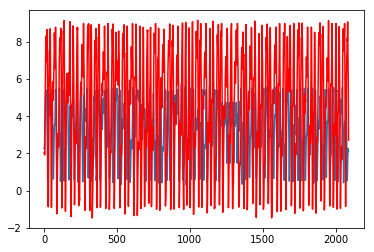

In [361]:
plt.plot(errors)
plt.plot(predictions, color='red')

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c44c30da0>]],
      dtype=object)

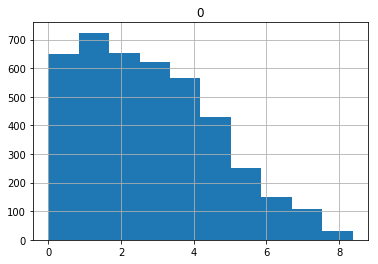

In [164]:
#residuals = pd.DataFrame(residuals)
#residuals.hist()

ADF Statistic: -23.739310
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


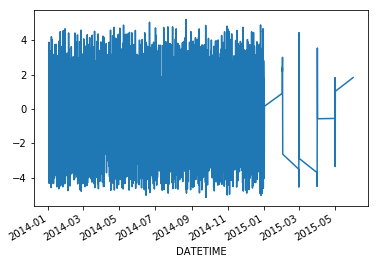

In [47]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
series = dataToPlot.iloc[:,1]
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

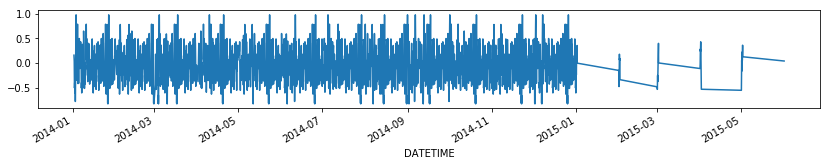

In [78]:
decomposition = sm.tsa.seasonal_decompose(dataToPlot.iloc[:,1],freq=400)
decompSeasonal = decomposition.seasonal
ax = decompSeasonal.plot(figsize=(14,2))

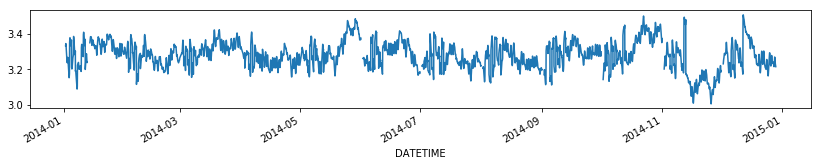

In [79]:
decompTrend = decomposition.trend
ax = decompTrend.plot(figsize=(14,2))

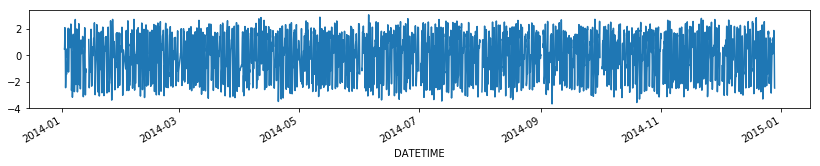

In [80]:
decompResid = decomposition.resid
ax = decompResid.plot(figsize=(14,2))

# PCA

In [373]:
## TODO use StandardScaler or not ? :S
#scaler = StandardScaler()
# Fit on training set only.
#scaler.fit(trainingTable)
# Apply transform to both the training set and the test set.
#train= scaler.transform(trainingTable)
#test = scaler.transform(dataToPlot2)
pca = PCA()
pca.fit(dataToPlot)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,0,'PCA features')

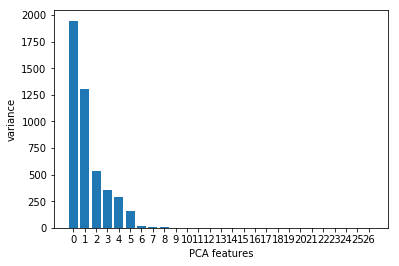

In [374]:
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA features')

In [375]:
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[4.22191584e-01 2.82770326e-01 1.15018353e-01 7.65981641e-02
 6.25299357e-02 3.37051574e-02 2.69754421e-03 1.68547018e-03
 1.18156987e-03 6.08096149e-04 3.25535684e-04 2.21732418e-04
 1.38608506e-04 8.19183345e-05 5.48797937e-05 4.71997166e-05
 3.95632472e-05 3.40883874e-05 2.95043299e-05 2.51469417e-05
 1.24072228e-05 2.76404386e-06 3.37801203e-07 1.12296576e-07
 4.50731870e-10 6.77390878e-11 1.63662504e-13]


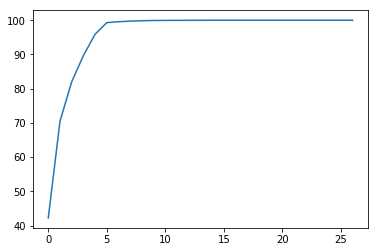

In [376]:
plt.plot(var1)
print(pca.explained_variance_ratio_) 

Text(0,0.5,'explained_variance_')

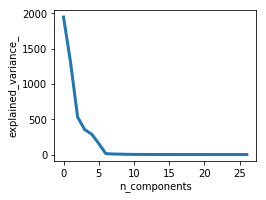

In [377]:
plt.figure(1, figsize=(4, 3))
plt.axes([.1, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [379]:
#Looking at above plot I'm taking 3 variables
pca = PCA(n_components=3)
pca.fit(trainingTable)
X1=pca.fit_transform(trainingTable)

print(X1)

[[-32.73904183  16.56280442 -30.64890295]
 [-32.76471422  16.22702619 -30.3250667 ]
 [-32.96841952  18.67066144 -30.16615669]
 ...
 [ 68.1804962   29.54135581  -1.33161323]
 [ 65.5508078   38.75235207   1.77881482]
 [ 67.66871287  32.95851347 -22.01825117]]


In [380]:
print(pca.explained_variance_ratio_)

[0.41935074 0.28317827 0.11419183]


In [339]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()#digits = datasets.load_digits()
X_digits = trainingTable
y_digits = dataToPlot2

# Plot the PCA spectrum
pca.fit(X_digits)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# TODO : TO CHECK IF IT'S NEED

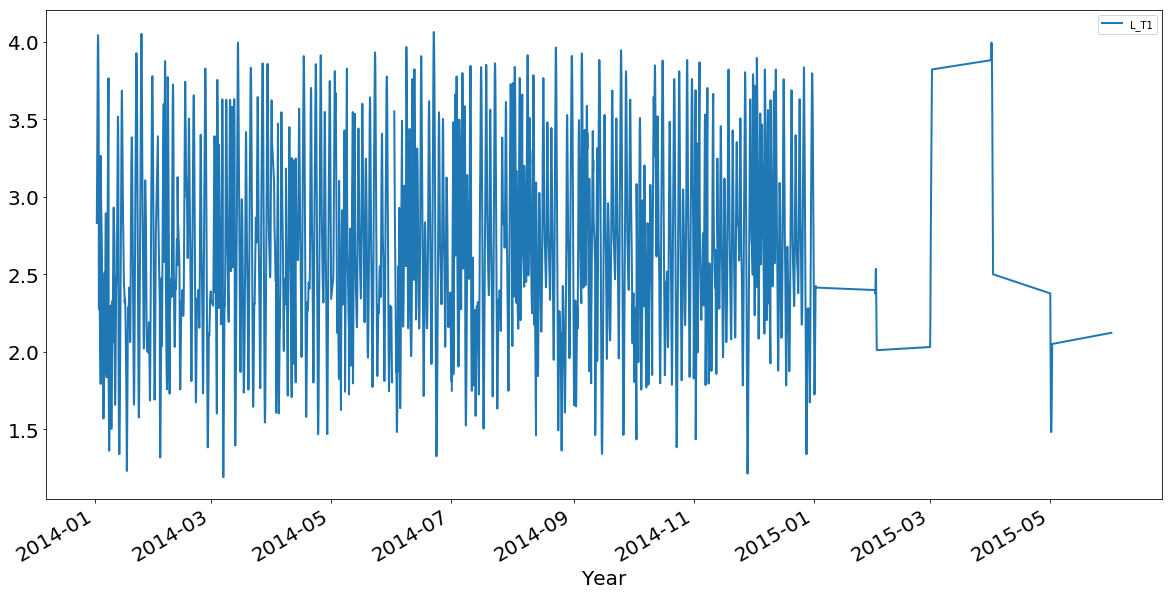

In [20]:
test = trainingTable1[['L_T1']]
test.rolling(30).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

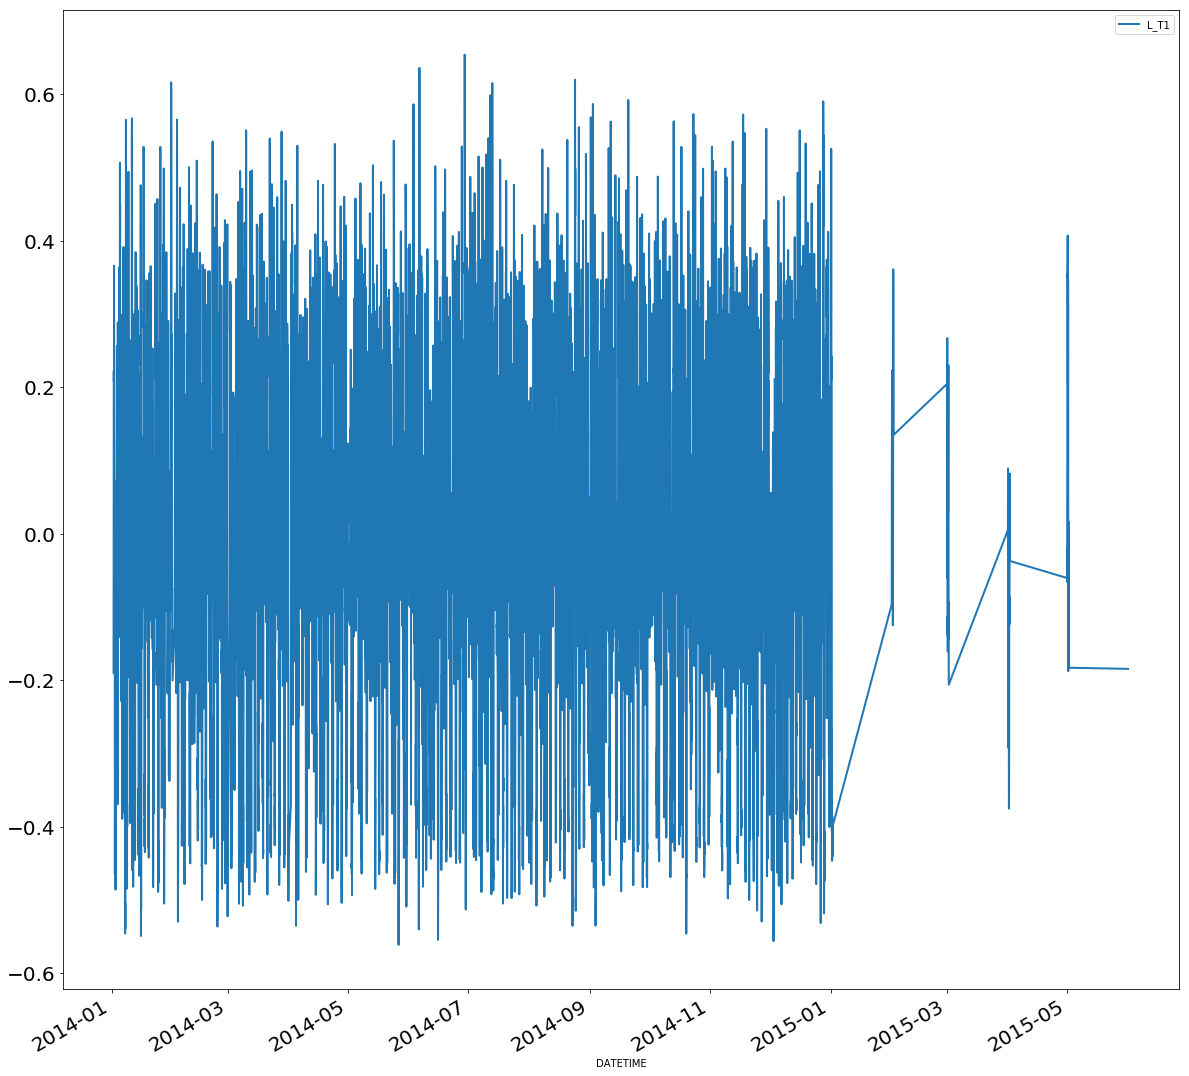

In [21]:
test.diff().plot(figsize=(20,20), linewidth=2, fontsize=20)

In [28]:
indexMonth = trainingTable1.index.month
dataByMonth = trainingTable1.groupby(indexMonth).mean()

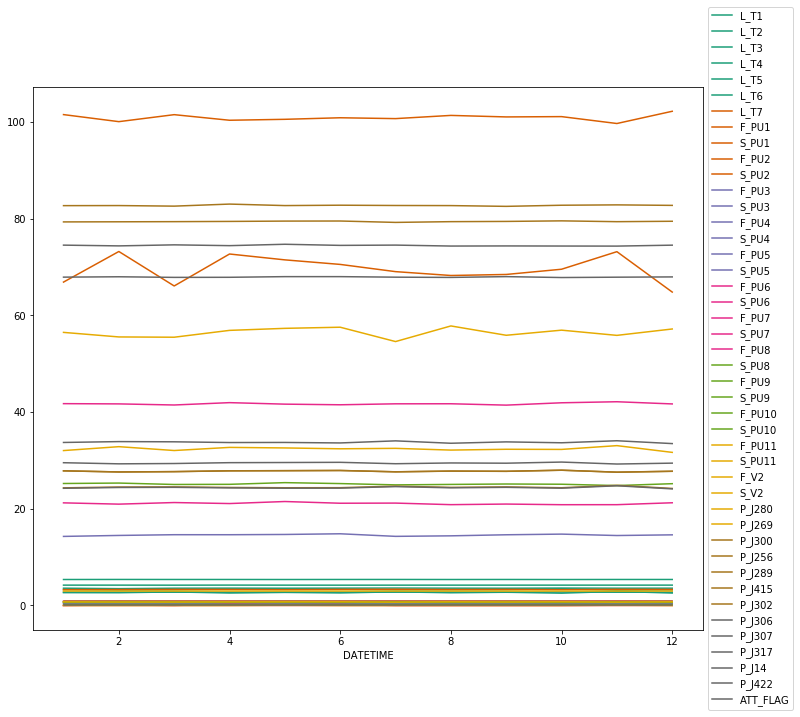

In [31]:
ax =  dataByMonth.plot(figsize=(12,10),colormap='Dark2')
ax.legend(bbox_to_anchor=(1.0,0.5),loc='center left')

In [344]:
trainingTable

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,F_PU4,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
DATETIME,,,,,,,,,,,,,,,,,,,,,
2014-06-01 00:00:00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,99.018150,35.536686,...,26.426495,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471
2014-06-01 01:00:00,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,99.115639,34.454914,...,26.422962,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256
2014-06-01 02:00:00,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,98.440498,33.487091,...,26.427771,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538
2014-06-01 03:00:00,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,97.594460,32.585545,...,26.519985,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952
2014-06-01 04:00:00,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,97.370277,31.469677,...,26.671642,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263
2014-06-01 05:00:00,0.791114,2.773177,5.155802,3.937262,3.191528,5.322743,3.988906,94.135468,94.153748,0.000000,...,31.443146,76.848953,31.443146,67.832695,30.366247,64.369881,30.366247,60.329407,33.749393,32.849392
2014-06-01 06:00:00,1.186589,3.536068,4.983953,3.018011,2.859591,5.066728,2.977463,95.258003,95.276611,0.000000,...,29.259064,75.703812,29.219223,87.435600,30.004425,63.333805,30.004425,58.606335,31.808870,30.908869
2014-06-01 07:00:00,1.420449,3.872926,4.747458,3.581882,2.359944,5.152646,2.953742,96.947456,96.966560,0.000000,...,29.200378,73.617569,29.160114,86.829086,26.536455,62.231846,26.414701,68.808609,31.700340,30.800341
2014-06-01 08:00:00,1.534827,4.138434,4.417932,3.959265,1.748313,5.395835,3.228596,96.970291,96.989403,0.000000,...,29.458397,74.182251,29.420120,89.644714,26.605623,60.656143,26.484545,69.221718,31.939442,31.039440
